Amazing Indian Magic
---

Reference
---
1. [Control, Google](https://www.kaggle.com/code/zjor86/simulations-double-inverted-pendulum)

In [1]:
!pip install -q control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 5.1 MB/s eta 0:00:00


In [4]:
import numpy as np
from numpy import sin, cos, pi

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
#plt.style.use('seaborn-whitegrid')

%matplotlib inline

In [5]:
def solve(initial_state, times, integrate_func, derivative_func):
    """
    Solves the initial-value problem of the first order ODEs
    :param initial_state: initial state
    :param times: a sequence of time points for which to solve
    :param integrate_func: calculates the next state
    :param derivative_func: computes derivatives of each state component
    :return:
    """
    dt = times[1] - times[0]
    states = [initial_state]
    for step, t in enumerate(times):
        states.append(integrate_func(states[-1], step, t, dt, derivative_func))
    return np.array(states)

In [6]:
def integrate_rk4(state, step, t, dt, dydx_func):
    """
    Fourth-order Runge-Kutta method.
    Source: https://www.geeksforgeeks.org/runge-kutta-4th-order-method-solve-differential-equation/
    :param step:
    :param state:
    :param t:
    :param dt:
    :param dydx_func:
    :return:
    """
    k1 = dydx_func(state, step, t, dt)
    k2 = dydx_func([v + d * dt / 2 for v, d in zip(state, k1)], step, t, dt)
    k3 = dydx_func([v + d * dt / 2 for v, d in zip(state, k2)], step, t, dt)
    k4 = dydx_func([v + d * dt for v, d in zip(state, k3)], step, t, dt)
    return [v + (k1_ + 2 * k2_ + 2 * k3_ + k4_) * dt / 6 for v, k1_, k2_, k3_, k4_ in zip(state, k1, k2, k3, k4)]

In [7]:
# model parameters
M = 5.0
m1 = 2.0
m2 = 1.5
l1 = 0.5
l2 = 0.25
g = 9.81

# initial state
X0 = 0.0  # cart position
dX0 = 0.0  # cart velocity
A0 = -0.2  # angle of the first joint
dA0 = 0.0  # angular velocity of the first joint
B0 = 0.1  # angle of the second joint
dB0 = 0.0  # angular velocity of the second joint


initial_state = np.array([X0, dX0, A0, dA0, B0, dB0])


In [8]:
def derivatives(state, step, t_, dt_):
    x, dx, a, da, b, db = state

    dL_dx = 0.0
    dL_da = -(m1 + m2) * l1 * da * dx * sin(a) + (m1 + m2) * g * l1 * sin(a) - m2 * l1 * l2 * da * db * sin(a - b)
    dL_db = m2 * l2 * (g * sin(b) + l1 * da * db * sin(a - b) - dx * db * sin(b))

    a11 = M + m1 + m2
    a12 = (m1 + m2) * l1 * cos(a)
    a13 = m2 * l2 * cos(b)
    b1 = (m1 + m2) * l1 * da ** 2 * sin(a) + m2 * l2 * db ** 2 * sin(b)

    a21 = (m1 + m2) * l1 * cos(a)
    a22 = (m1 + m2) * l1 ** 2
    a23 = m2 * l1 * l2 * cos(a - b)
    b2 = (m1 + m2) * dx * da * l1 * sin(a) + m2 * l1 * l2 * db * (da - db) * sin(a - b)

    a31 = m2 * l2 * cos(b)
    a32 = m2 * l1 * l2 * cos(a - b)
    a33 = m2 * l2 ** 2
    b3 = m2 * dx * db * l2 * sin(b) + m2 * l1 * l2 * da * (da - db) * sin(a - b)

    A = np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    b_vec = np.array([b1 + dL_dx, b2 + dL_da, b3 + dL_db])
    det_A = np.linalg.det(A)

    Ax = np.copy(A)
    Ax[:, 0] = b_vec
    ddx = np.linalg.det(Ax) / det_A

    Aa = np.copy(A)
    Aa[:, 1] = b_vec
    dda = np.linalg.det(Aa) / det_A

    Ab = np.copy(A)
    Ab[:, 2] = b_vec
    ddb = np.linalg.det(Ab) / det_A
    return [dx, ddx, da, dda, db, ddb]

In [9]:
times = np.linspace(0, 6, 6000)
dt = times[1] - times[0]

solution = solve(initial_state, times, integrate_rk4, derivatives)

In [10]:
def render(solution):
    x_solution = solution[:, 0]
    a_solution = solution[:, 2]
    b_solution = solution[:, 4]

    skip_frames = 40

    x_solution = x_solution[::skip_frames]
    a_solution = a_solution[::skip_frames]
    b_solution = b_solution[::skip_frames]

    frames = len(x_solution)

    j1_x = l1 * sin(a_solution) + x_solution
    j1_y = l1 * cos(a_solution)

    j2_x = l2 * sin(b_solution) + j1_x
    j2_y = l2 * cos(b_solution) + j1_y

    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1))
    ax.set_aspect('equal')
    ax.grid()

    patch = ax.add_patch(Rectangle((0, 0), 0, 0, linewidth=1, edgecolor='k', facecolor='r'))

    line, = ax.plot([], [], 'o-', lw=2)
    time_template = 'time: %.1f s'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

    cart_width = 0.15
    cart_height = 0.1


    def init():
        line.set_data([], [])
        time_text.set_text('')
        patch.set_xy((-cart_width / 2, -cart_height / 2))
        patch.set_width(cart_width)
        patch.set_height(cart_height)
        return line, time_text


    def animate(i):
        thisx = [x_solution[i], j1_x[i], j2_x[i]]
        thisy = [0, j1_y[i], j2_y[i]]

        line.set_data(thisx, thisy)
        now = i * skip_frames * dt
        time_text.set_text(time_template % now)

        patch.set_x(x_solution[i] - cart_width / 2)
        return line, time_text, patch


    ani = animation.FuncAnimation(fig, animate, frames=frames,
                                  interval=1, blit=True, init_func=init)
    plt.close(fig)
    return ani

In [11]:
ani = render(solution)
%time ani.save('free_dipc.gif', writer='imagemagick', fps=24)

CPU times: user 11.3 s, sys: 575 ms, total: 11.9 s
Wall time: 12.2 s


In [12]:
!apt install imagemagick


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  imagemagick-6.q16 libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libwmflite-0.2-7 netpbm
  poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x imagemagick-doc
  autotrace cups-bsd | lpr | lprng enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer
  povray radiance sane-utils texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev
  inkscape poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nan

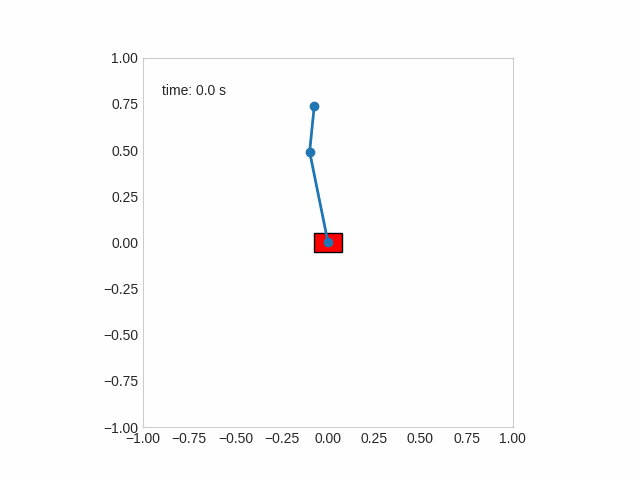

In [13]:
from IPython.display import Image
Image(open('free_dipc.gif','rb').read())

In [14]:
from numpy.linalg import matrix_rank, inv
from control import ctrb, obsv

In [15]:
def get_a_b(M, m1, m2, l1, l2):
    X = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, M + m1 + m2, l1 * (m1 + m2), l2 * m2],
        [0, 0, 0, l1 * (m1 + m2), l1 ** 2 * (m1 + m2), l1 * l2 * m2],
        [0, 0, 0, l2 * m2, l1 * l2 * m2, l2 ** 2 * m2]
    ], dtype="float64")
    N = np.array([
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [0, (m1 + m2) * l1 * g, 0, 0, 0, 0],
        [0, 0, m2 * l2 * g, 0, 0, 0]
    ], dtype="float64")
    F = np.array([[0, 0, 0, 1, 0, 0]], dtype="float64").T
    X_inv = inv(X)
    A = X_inv @ N
    B = inv(X) @ F
    return A, B


In [16]:
def check_ctrb_obsv(A, B, C):
    ctrb_matrix = ctrb(A, B)
    obsv_matrix = obsv(A, C)

    print("Controllability matrix rank: %d" % matrix_rank(ctrb_matrix))
    print("Observability matrix rank: %d" % matrix_rank(obsv_matrix))

In [17]:
# rank 6 means the system is controllable and observable
A, B = get_a_b(M, m1, m2, l1, l2)
check_ctrb_obsv(A, B, C=np.array([[1, 1, 1, 0, 0, 0]]))

Controllability matrix rank: 6
Observability matrix rank: 6


In [18]:
"""
    Source: http://www.kostasalexis.com/lqr-control.html
"""
import scipy.linalg

def lqr(A, B, Q, R):
    """
        Solve the continuous time lqr controller.
        dx/dt = A x + B u
        cost = integral x.T*Q*x + u.T*R*u
    """
    # ref Bertsekas, p.151
    # first, try to solve the ricatti equation
    X = np.array(scipy.linalg.solve_continuous_are(A, B, Q, R))
    # compute the LQR gain
    K = np.array(scipy.linalg.inv(R) @ (B.T @ X))
    eigVals, eigVecs = scipy.linalg.eig(A - B @ K)
    return K, X, eigVals

In [19]:
def get_lqr_gains(A, B, Q, R):
    K, _, _ = lqr(A, B, Q, R)
    return K


In [20]:
Q = np.array([
    [1000000., .0, .0, .0, .0, .0],
    [.0, 1., .0, .0, .0, .0],
    [.0, .0, 1., .0, .0, .0],
    [.0, .0, .0, 1., .0, .0],
    [.0, .0, .0, .0, 1., .0],
    [.0, .0, .0, .0, .0, 1.],
])

R = np.array([[2000.]])
A, B = get_a_b(M, m1, m2, l1, l2)
K = get_lqr_gains(A, B, Q, R)

In [21]:
disable_control_threshold = 3.0


def get_control(state, t):
    """
    Returns control based on LQR gains and disables after time threshold
    """
    x, dx, a, da, b, db = state
    if t < disable_control_threshold:
        _state = np.array([[x, a, b, dx, da, db]])
        return (-K @ _state.T)[0, 0]
    else:
        return .0

def derivatives(state, step, t_, dt_):
    x, dx, a, da, b, db = state

    u = get_control(state, t_)

    dL_dx = 0.0
    dL_da = -(m1 + m2) * l1 * da * dx * sin(a) + (m1 + m2) * g * l1 * sin(a) - m2 * l1 * l2 * da * db * sin(a - b)
    dL_db = m2 * l2 * (g * sin(b) + l1 * da * db * sin(a - b) - dx * db * sin(b))

    a11 = M + m1 + m2
    a12 = (m1 + m2) * l1 * cos(a)
    a13 = m2 * l2 * cos(b)
    b1 = (m1 + m2) * l1 * da ** 2 * sin(a) + m2 * l2 * db ** 2 * sin(b)

    a21 = (m1 + m2) * l1 * cos(a)
    a22 = (m1 + m2) * l1 ** 2
    a23 = m2 * l1 * l2 * cos(a - b)
    b2 = (m1 + m2) * dx * da * l1 * sin(a) + m2 * l1 * l2 * db * (da - db) * sin(a - b)

    a31 = m2 * l2 * cos(b)
    a32 = m2 * l1 * l2 * cos(a - b)
    a33 = m2 * l2 ** 2
    b3 = m2 * dx * db * l2 * sin(b) + m2 * l1 * l2 * da * (da - db) * sin(a - b)

    A = np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    b_vec = np.array([b1 + dL_dx + u, b2 + dL_da, b3 + dL_db])
    det_A = np.linalg.det(A)

    Ax = np.copy(A)
    Ax[:, 0] = b_vec
    ddx = np.linalg.det(Ax) / det_A

    Aa = np.copy(A)
    Aa[:, 1] = b_vec
    dda = np.linalg.det(Aa) / det_A

    Ab = np.copy(A)
    Ab[:, 2] = b_vec
    ddb = np.linalg.det(Ab) / det_A
    return [dx, ddx, da, dda, db, ddb]


In [22]:
times = np.linspace(0, 6, 6000)
dt = times[1] - times[0]

solution = solve(initial_state, times, integrate_rk4, derivatives)


In [23]:
ani = render(solution)
%time ani.save('DoublePendulum.gif', writer='imagemagick', fps=24)

CPU times: user 11 s, sys: 314 ms, total: 11.3 s
Wall time: 41 s


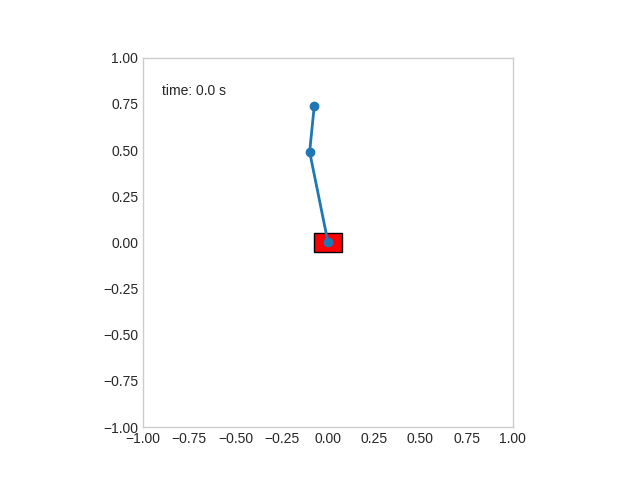

In [24]:
Image(open('DoublePendulum.gif','rb').read())

References
---
1. [Equations of motion](https://www3.math.tu-berlin.de/Vorlesungen/SoSe12/Kontrolltheorie/matlab/inverted_pendulum.pdf)
2. [Stability Control of Double Inverted Pendulum on a Cart using Full State](https://www.scienceopen.com/hosted-document?doi=10.14293/S2199-1006.1.SOR-.PP0CSDR.v1)
3. [Source code](https://github.com/zjor/snippets/tree/master/python/ode_solver/examples/double_inverted_pendulum)